In [1]:
import cv2
import numpy as np
import dlib
import os
import glob
from imutils import face_utils
from tqdm import tqdm  # 진행률 시각화를 위한 라이브러리

In [2]:
def extract_face_and_skin(image):
    # dlib 초기화
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('res/shape_predictor_68_face_landmarks.dat')

    # 얼굴 검출
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return None, None  # 얼굴 미검출 시 None 반환

    rect = rects[0]  # 첫 번째 얼굴만 처리
    shape = predictor(gray, rect)
    shape_np = face_utils.shape_to_np(shape)

    # 얼굴 크롭
    (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
    cropped_face = image[max(0, y):y+h, max(0, x):x+w]

    # YCrCb 변환 및 피부 마스크 생성
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lower_ycrcb = np.array([0, 133, 77], dtype=np.uint8)
    upper_ycrcb = np.array([255, 173, 127], dtype=np.uint8)
    skin_mask = cv2.inRange(ycrcb, lower_ycrcb, upper_ycrcb)
    skin = cv2.bitwise_and(image, image, mask=skin_mask)

    return cropped_face, skin


In [3]:
def extract_color_features(skin_region):
    # YCrCb 변환
    ycrcb = cv2.cvtColor(skin_region, cv2.COLOR_BGR2YCrCb)
    y_channel = ycrcb[:, :, 0]
    b_channel = ycrcb[:, :, 2]

    # HSV 변환
    hsv = cv2.cvtColor(skin_region, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:, :, 1]

    # 평균값 계산
    y_mean = np.mean(y_channel)
    b_mean = np.mean(b_channel)
    s_mean = np.mean(s_channel)

    return y_mean, b_mean, s_mean


In [4]:
# 데이터 경로 설정
image_paths = glob.glob("data/00000/*.png")

# 결과 저장 리스트
data = []

for img_path in tqdm(image_paths):
    image = cv2.imread(img_path)

    # 얼굴 크롭 및 피부 영역 추출
    cropped_face, skin = extract_face_and_skin(image)
    if skin is not None:
        # Y, b, S 값 추출
        y, b, s = extract_color_features(skin)

        # 이미지 파일명과 값 저장
        data.append({"image": os.path.basename(img_path), "Y": y, "b": b, "S": s})

# 저장
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("color_features.csv", index=False)
print("Data saved to color_features.csv")


100%|██████████| 1000/1000 [13:19<00:00,  1.25it/s]


Data saved to color_features.csv


In [5]:
color_data = pd.read_csv("color_features.csv")

In [10]:
# pd.DataFrame(color_data["Y"].mean(), color)
color_data.describe()

,Y,b,S
count,989.000000,989.000000,989.000000
mean,72.655248,118.637792,64.541248
std,25.043949,4.460780,28.285611
min,4.491590,97.150123,1.294664
25%,54.605542,116.172913,44.914500
50%,69.711195,119.359173,59.271823
75%,88.139114,121.844668,79.983958
max,159.322329,127.935595,168.412297


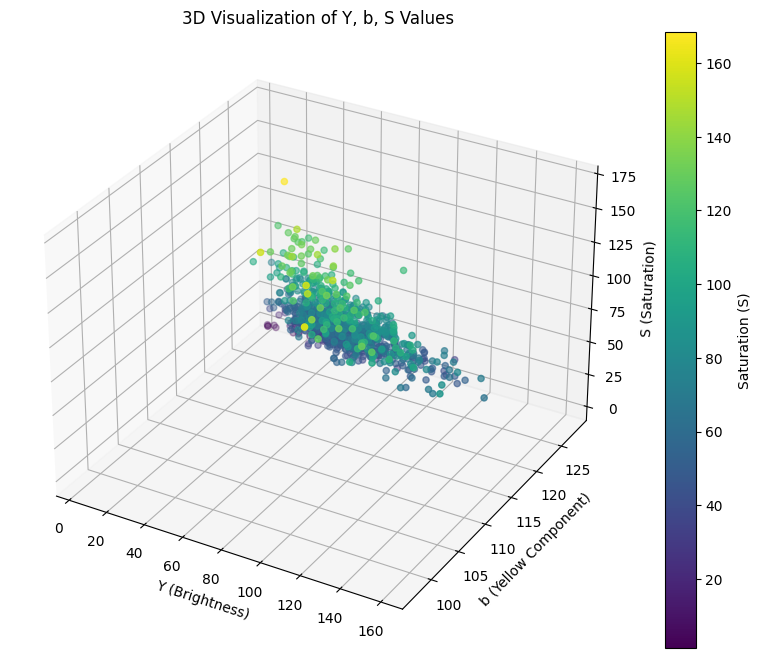

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

try:    
    # Y, b, S 값 추출
    y_values = color_data["Y"]
    b_values = color_data["b"]
    s_values = color_data["S"]
    
    # 3D 시각화
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(y_values, b_values, s_values, c=s_values, cmap='viridis', marker='o')
    
    ax.set_title("3D Visualization of Y, b, S Values")
    ax.set_xlabel("Y (Brightness)")
    ax.set_ylabel("b (Yellow Component)")
    ax.set_zlabel("S (Saturation)")
    plt.colorbar(scatter, label="Saturation (S)")
    plt.show()
except FileNotFoundError:
    print("The file 'color_features.csv' was not found. Please check the file path.")
